In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from datetime import datetime
from google.colab import files, drive
import io, os


from sklearn.datasets import load_digits
from scipy.spatial.distance import pdist
from sklearn.manifold.t_sne import _joint_probabilities
from scipy import linalg
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import squareform
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 10)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.manifold.t_sne module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.manifold. Anything that cannot be imported from sklearn.manifold is now part of the private API.
  warnings.warn(message, FutureWarning)


t-SNE = redução de dimensionalidade usando a distância entre os pontos, só que está distância é utilizada em uma distribuição de probabilidade de tal forma que os pontos mais próximos possui probabilidade alta e pontos mais distantes possui probabilidade baixa de pertencer a um determinado grupo.

https://towardsdatascience.com/t-sne-python-example-1ded9953f26<br>
https://medium.com/@violante.andre/an-introduction-to-t-sne-with-python-example-47e6ae7dc58f<br>
https://www.reneshbedre.com/blog/tsne.html<br>
https://towardsdatascience.com/kl-divergence-python-example-b87069e4b810

In [ ]:
# importando dataset de digitos manuscritos
X, y = load_digits(return_X_y=True)
print(X.shape, y.shape)

(1797, 64) (1797,)


In [ ]:
MACHINE_EPSILON = np.finfo(np.double).eps #menor número que o computador consegue manipular, menor que este falta bit.
n_components = 2 #número de dimensões que será reduzido.
perplexity = 30  #número de vizinhos próximos usado no algoritmo (30 é o padro do sk-learn)

In [ ]:
def fit(X):
  n_samples = X.shape[0]

  #calcula distância euclidiana - gera uma matriz de distância entre todo os pontos de X
  distances = pairwise_distances(X, metric='euclidean', squared=True)
  print(distances.shape)

  #calcula a probabilidade condicional p(j|i) a partir das distâncias para cada ponto de dados.  )
  P = _joint_probabilities(distances=distances, desired_perplexity=perplexity, verbose=False)
  print(P.shape)

  #inicializa as embedding com distribuição Gaussiana e std = 1e-4
  #np.random.mtrand._rand.randn = Cria uma matriz da forma fornecida e preencha-a com amostras aleatórias de uma distribuição uniforme
  #graus de liberdade = nro de componentes -1
  X_embedded = 1e-4 * np.random.mtrand._rand.randn(n_samples, n_components).astype(np.float32)
  degrees_of_freedom = max(n_components - 1, 1)
  return _tsne(P, degrees_of_freedom, n_samples, X_embedded=X_embedded)


In [ ]:
def _tsne(P, degrees_of_freedom, n_samples, X_embedded):
  params = X_embedded.ravel() #transforma em um array de 1-D, necessidade da funçaõ kl_divergence
  obj_func = _kl_divergence #Distancia de Kullback-Leibler - quantifica a diferença entre duas distribuição de probabilidade: https://towardsdatascience.com/kl-divergence-python-example-b87069e4b810
  #utiliza a descida do gradiente para achar a menor probab entre os pontos, isto é, minimiza a kl_divergence
  params = _gradient_descent(obj_func, params, [P, degrees_of_freedom, n_samples, n_components]) 
  X_embedded = params.reshape(n_samples, n_components) #volta a matriz para o formato inicial
  return X_embedded

In [ ]:
def _kl_divergence(params, P, degrees_of_freedom, n_samples, n_components):
    '''será calculada a distribuição de probabilidade t-student para os pontos'''
    X_embedded = params.reshape(n_samples, n_components)
    #calcula a distribuição de probabilidade sobre a distância euclidiana entre os pontos
    dist = pdist(X_embedded, "sqeuclidean")
    #divide as probabilidades das distâncias pelo grau de liberdade
    dist /= degrees_of_freedom
    #soma 1 ao resultado da divisão
    dist += 1.
    #eleva a pontência: -(grau_de_liberd +1)/2
    dist **= (degrees_of_freedom + 1.0) / -2.0
    #obtem o maior valor entre a  distrib de probab t-student para os pontos e o valor que os processadores conseguem calcular
    Q = np.maximum(dist / (2.0 * np.sum(dist)), MACHINE_EPSILON)
    
    # Kullback-Leibler divergence of P and Q
    kl_divergence = 2.0 * np.dot(P, np.log(np.maximum(P, MACHINE_EPSILON) / Q))
    
    # Gradient: dC/dY - calcula derivada parcial para minimizar a divergencia KL 
    grad = np.ndarray((n_samples, n_components), dtype=params.dtype)
    PQd = squareform((P - Q) * dist)
    for i in range(n_samples):
        grad[i] = np.dot(np.ravel(PQd[i], order='K'),
                         X_embedded[i] - X_embedded)
    grad = grad.ravel()
    c = 2.0 * (degrees_of_freedom + 1.0) / degrees_of_freedom
    grad *= c
    return kl_divergence, grad

In [ ]:
def _gradient_descent(obj_func, p0, args, it=0, n_iter=1000,
                      n_iter_check=1, n_iter_without_progress=300,
                      momentum=0.8, learning_rate=200.0, min_gain=0.01,
                      min_grad_norm=1e-7):
    
    p = p0.copy().ravel()
    update = np.zeros_like(p)
    gains = np.ones_like(p)
    error = np.finfo(np.float).max
    best_error = np.finfo(np.float).max
    best_iter = i = it
    
    for i in range(it, n_iter):
      error, grad = obj_func(p, *args)
      grad_norm = linalg.norm(grad)
      inc = update * grad < 0.0
      dec = np.invert(inc)
      gains[inc] += 0.2
      gains[dec] *= 0.8
      np.clip(gains, min_gain, np.inf, out=gains)
      grad *= gains
      update = momentum * update - learning_rate * grad
      p += update
      print("[t-SNE] Iteration %d: error = %.7f,"
                            " gradient norm = %.7f"
                            % (i + 1, error, grad_norm))
              
      if error < best_error:
              best_error = error
              best_iter = i
      elif i - best_iter > n_iter_without_progress:
          break
      
      if grad_norm <= min_grad_norm:
          break
    return p

In [ ]:
X_embedded = fit(X)

(1797, 1797)
(1613706,)
[t-SNE] Iteration 1: error = 4.0229677, gradient norm = 0.0000049
[t-SNE] Iteration 2: error = 4.0229676, gradient norm = 0.0000049
[t-SNE] Iteration 3: error = 4.0229676, gradient norm = 0.0000059
[t-SNE] Iteration 4: error = 4.0229676, gradient norm = 0.0000090
[t-SNE] Iteration 5: error = 4.0229676, gradient norm = 0.0000153
[t-SNE] Iteration 6: error = 4.0229674, gradient norm = 0.0000277
[t-SNE] Iteration 7: error = 4.0229668, gradient norm = 0.0000534
[t-SNE] Iteration 8: error = 4.0229641, gradient norm = 0.0001091
[t-SNE] Iteration 9: error = 4.0229516, gradient norm = 0.0002350
[t-SNE] Iteration 10: error = 4.0228878, gradient norm = 0.0005318
[t-SNE] Iteration 11: error = 4.0225310, gradient norm = 0.0012574
[t-SNE] Iteration 12: error = 4.0203723, gradient norm = 0.0030692
[t-SNE] Iteration 13: error = 4.0069025, gradient norm = 0.0072960
[t-SNE] Iteration 14: error = 3.9360707, gradient norm = 0.0137672
[t-SNE] Iteration 15: error = 3.7216961, gradie

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


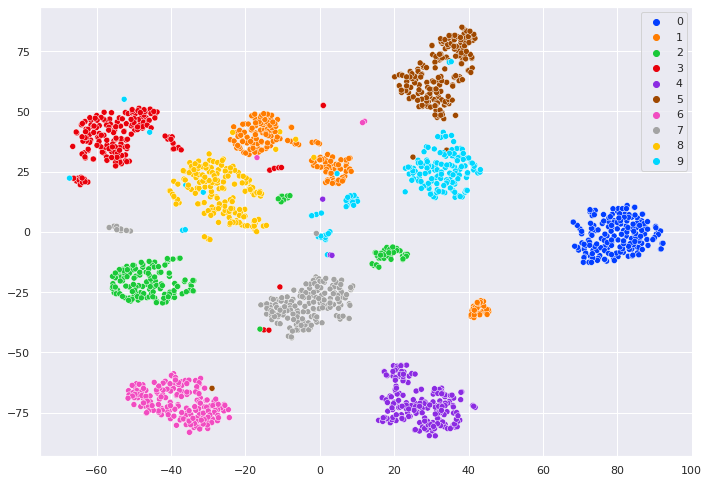

In [ ]:
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y, legend='full', palette=palette)

In [ ]:
#usando implementação do sckit
tsne = TSNE()
X_embedded = tsne.fit_transform(X)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


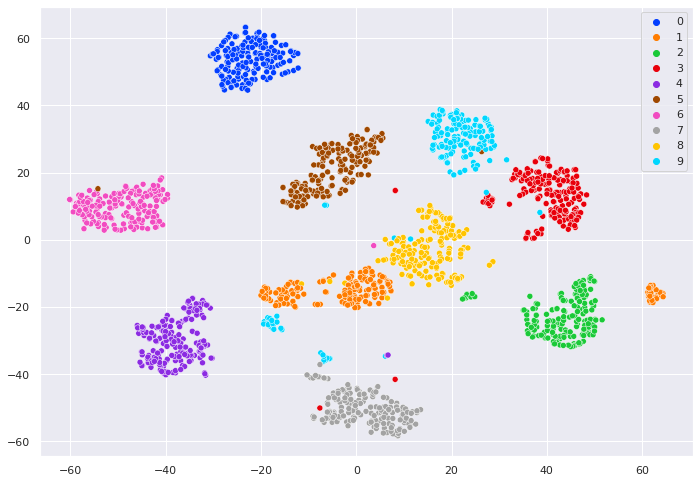

In [ ]:
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y, legend='full', palette=palette)